# AI Deep Learning Model by Andy Chou

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [ ]:
# (Example)-Help company to train the AI model of pets identification for building their own products.

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/andy/pets",
    validation_split=0.2,
    subset="training",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/andy/pets",
    validation_split=0.2,
    subset="validation",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
)


Found 2258 files belonging to 2 classes.
Using 1807 files for training.
Found 2258 files belonging to 2 classes.
Using 451 files for validation.


2025-02-16 16:45:05.687135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


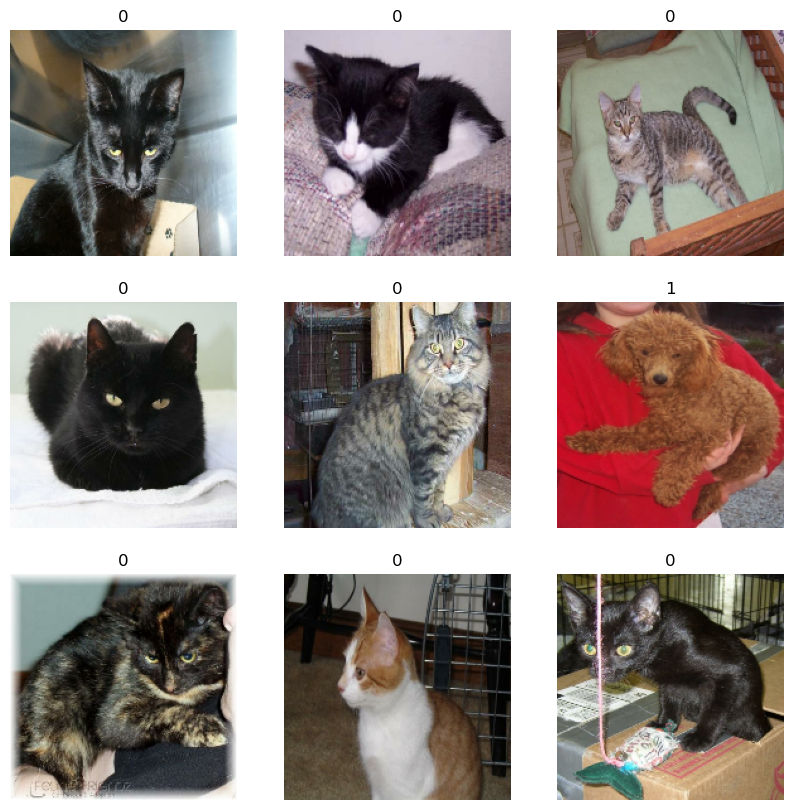

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [ ]:
# Data Augmentation

from tensorflow.keras import Sequential
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
    ]
)


2025-02-16 16:45:10.146744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


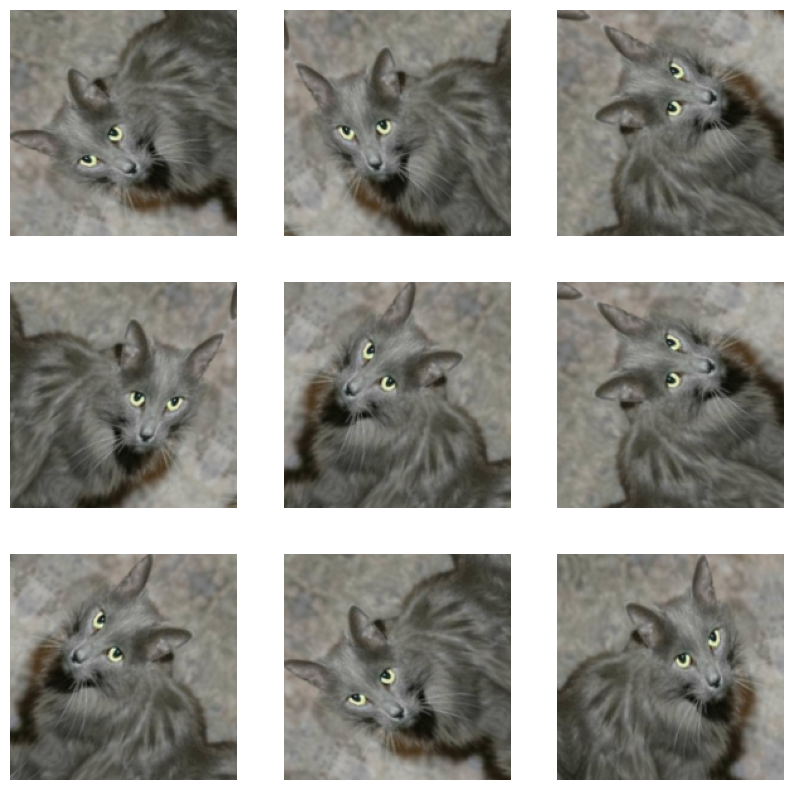

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# Prefetch to optimize the speed of training.

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)


    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)


# Use Depthwise Separable Convolution and ResNet v2 for model building

    previous_block_activation = x

    for size in [128, 256, 512, 728]:

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x) # For dimensionality reduction

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x


    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 180, 180,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 90, 90,    │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 90, 90,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 90, 90,    │     18,496 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 90, 90,    │          0 │ activation_1[0][… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 90, 90,    │      8,896 │ activation_2[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 90, 90,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 90, 90,    │     17,664 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 90,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 45, 45,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 45, 45,    │      8,320 │ activation_1[0][

 Total params: 2,782,649 (10.61 MB)

 Trainable params: 2,773,913 (10.58 MB)

 Non-trainable params: 8,736 (34.12 KB)

In [ ]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 30

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.5608 - loss: 0.8204 - val_accuracy: 0.4678 - val_loss: 0.7036
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6029 - loss: 0.7018 - val_accuracy: 0.4678 - val_loss: 0.7369
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.6601 - loss: 0.6400 - val_accuracy: 0.4678 - val_loss: 0.7818
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.6443 - loss: 0.6316 - val_accuracy: 0.4678 - val_loss: 0.8418
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.6675 - loss: 0.6143 - val_accuracy: 0.4678 - val_loss: 0.8433
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.6984 - loss: 0.5859 - val_accuracy: 0.4678 - val_loss: 0.8897
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.7130 - loss: 0.5670 - val_accuracy: 0.4678 - val_loss: 1.0154
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.7471 - loss: 0.5461 - val_accuracy: 0.4922 - v

In [ ]:
img = keras.preprocessing.image.load_img(
    "/Users/andy/pets/Cat/5.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
This image is 87.16 percent cat and 12.84 percent dog.


/var/folders/96/wpcs29j12nd_vynlpjlhhfxr0000gn/T/ipykernel_7570/2282331732.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "This image is %.2f percent cat and %.2f percent dog."


In [ ]:
img = keras.preprocessing.image.load_img(
    "/Users/andy/pets/Dog/4.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
This image is 0.00 percent cat and 100.00 percent dog.


/var/folders/96/wpcs29j12nd_vynlpjlhhfxr0000gn/T/ipykernel_7570/869221637.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "This image is %.2f percent cat and %.2f percent dog."


In [ ]:
img = keras.preprocessing.image.load_img(
    "/Users/andy/pets/Dog/31.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
This image is 1.25 percent cat and 98.75 percent dog.


/var/folders/96/wpcs29j12nd_vynlpjlhhfxr0000gn/T/ipykernel_7570/1340407142.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "This image is %.2f percent cat and %.2f percent dog."


In [ ]:
testing_dir='/Users/andy/pet_testing_images'

In [ ]:
for images in os.listdir(testing_dir):
  img = keras.preprocessing.image.load_img(os.path.join(testing_dir, images), target_size=image_size )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array)
  score = predictions[0]
  print(images, ", This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score) )
# %%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
63.jpg , This image is 20.05 percent cat and 79.95 percent dog.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1145.jpg , This image is 8.25 percent cat and 91.75 percent dog.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1144.jpg , This image is 3.14 percent cat and 96.86 percent dog.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
62.jpg , This image is 63.31 percent cat and 36.69 percent dog.


/var/folders/96/wpcs29j12nd_vynlpjlhhfxr0000gn/T/ipykernel_12714/827363326.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(images, ", This image is %.2f percent cat and %.2f percent dog."


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
60.jpg , This image is 11.33 percent cat and 88.67 percent dog.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1146.jpg , This image is 2.89 percent cat and 97.11 percent dog.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1147.jpg , This image is 0.56 percent cat and 99.44 percent dog.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1143.jpg , This image is 0.47 percent cat and 99.53 percent dog.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1142.jpg , This image is 9.12 percent cat and 90.88 percent dog.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
64.jpg , This image is 39.66 percent cat and 60.34 percent dog.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
58.jpg , This image is 81.53 percent cat and 18.47 percent dog.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
s_cat.jpeg , This image is 8.44 percent cat and 91.56 percent dog.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
s_dog.jpeg , This image is 3.08 percent cat and 96.92 percent dog.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1149.jpg , This image is 5.24 perc